In [1]:
# Set project root
import os
import sys

# Manually set the path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import json

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.measurement_data import load_measurements_from_yaml

## Function definition

In [3]:
def load_calibration_json(filename):
    with open(filename) as f:
        data = json.load(f)

    camera_matrix = np.array(data['camera_matrix'])
    dist_coeff = np.array(data['dist_coeff'])
    image_size = tuple(data['image_size'])

    return camera_matrix, dist_coeff, image_size

In [4]:
def load_rgb(path):
    """
    Load image from path and convert to RGB.
    """
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise FileNotFoundError(f"Image not found: {path}")
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    return rgb

def extract_features(image, method='SIFT'):
    """
    Detect keypoints and compute descriptors.

    Args:
        image: RGB image as numpy array.
        method: Feature detector ('SIFT', 'ORB', etc.).
    Returns:
        keypoints, descriptors
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if method == 'SIFT':
        detector = cv2.SIFT_create()
    elif method == 'ORB':
        detector = cv2.ORB_create(nfeatures=2000)
    else:
        raise ValueError(f"Unsupported method: {method}")
    keypoints, descriptors = detector.detectAndCompute(gray, None)
    return keypoints, descriptors

def match_descriptors(desc1, desc2, method='BF', cross_check=True):
    """
    Match feature descriptors between two images.

    Args:
        desc1: Descriptors from image 1.
        desc2: Descriptors from image 2.
        method: 'BF' for BruteForce, 'FLANN' for FLANN matcher.
        cross_check: (BF only) whether to use crossCheck.
    Returns:
        List of matches sorted by distance.
    """
    if method == 'BF':
        # Choose norm by descriptor type
        norm = cv2.NORM_L2 if desc1.dtype == np.float32 else cv2.NORM_HAMMING
        matcher = cv2.BFMatcher(norm, crossCheck=cross_check)
        matches = matcher.match(desc1, desc2)
    elif method == 'FLANN':
        # FLANN parameters for SIFT
        index_params = dict(algorithm=1, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        raw_matches = matcher.knnMatch(desc1, desc2, k=2)
        # Ratio test
        matches = [m[0] for m in raw_matches if len(m) == 2 and m[0].distance < 0.75 * m[1].distance]
    else:
        raise ValueError(f"Unsupported matcher: {method}")
    matches = sorted(matches, key=lambda x: x.distance)
    return matches

def compute_homography(kp1, kp2, matches, ransac_thresh=5.0):
    """
    Compute homography using matched keypoints.

    Args:
        kp1, kp2: Keypoints from image1 and image2.
        matches: List of cv2.DMatch objects.
        ransac_thresh: RANSAC reprojection threshold.
    Returns:
        homography matrix H, mask of inliers
    """
    if len(matches) < 4:
        raise ValueError("Not enough matches to compute homography")
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, ransac_thresh)
    return H, mask

def visualize_homography(template, image, H, title='Homography Overlay'):
    """
    Warp template by H and overlay on image.
    """
    h_t, w_t = template.shape[:2]
    corners = np.float32([[0, 0], [w_t, 0], [w_t, h_t], [0, h_t]]).reshape(-1, 1, 2)
    warped_corners = cv2.perspectiveTransform(corners, H)
    overlay = image.copy()
    pts = np.int32(warped_corners)
    cv2.polylines(overlay, [pts], True, (255, 0, 0), 3)
    plt.figure(figsize=(8, 6))
    plt.imshow(overlay)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [5]:
def template_match(template_path, scene_path, extract_method='SIFT', match_method='BF'):
    tpl = load_rgb(template_path)
    img = load_rgb(scene_path)
    kp_t, desc_t = extract_features(tpl, method=extract_method)
    kp_i, desc_i = extract_features(img, method=extract_method)
    matches = match_descriptors(desc_t, desc_i, method=match_method)
    H, mask = compute_homography(kp_t, kp_i, matches)
    visualize_homography(tpl, img, H, title='Template Matching Result')
    return H, mask, tpl.shape[:2]

In [6]:
def compute_metric_homography(
    H_px: np.ndarray,
    template_size_px: tuple[float, float],
    template_size_metric: tuple[float, float]
) -> np.ndarray:
    """
    Compute a homography that maps real-world template coordinates (in metric units)
    to image pixel coordinates.

    Parameters:
    -----------
    H_tpl2img : np.ndarray, shape (3,3)
        Homography mapping template image pixel coordinates [u_px, v_px, 1]^T
        to scene image pixel coordinates [u_img, v_img, 1]^T. Obtained, for example,
        via feature matching and cv2.findHomography between a template image and scene.

    template_size_px : Tuple[float, float]
        (width_px, height_px) — the dimensions of the template image in pixels.

    template_size_metric : Tuple[float, float]
        (width_m, height_m) — the real-world dimensions of the template
        in metric units (e.g., millimeters).

    Returns:
    --------
    H_metric2img : np.ndarray, shape (3,3)
        Homography mapping template real-world coordinates [X, Y, 1]^T (in metric units)
        directly to scene image pixel coordinates [u_img, v_img, 1]^T.

    Raises:
    -------
    ValueError
        If the metric-to-image homography cannot be computed.
    """
    # Unpack dimensions
    h_px, w_px = template_size_px
    h_m, w_m = template_size_metric

    # Step 1: Define the four template corners in template-image pixel coordinates
    # Order: top-left, top-right, bottom-right, bottom-left
    corners_px = np.array([
        [0.0, 0.0],
        [w_px, 0.0],
        [w_px, h_px],
        [0.0, h_px]
    ], dtype=np.float32)

    # # Convert to homogeneous coordinates (4×3)
    # corners_px_hom = np.hstack([corners_px, np.ones((4, 1), dtype=np.float32)])

    # # Step 2: Project through the initial homography to get scene image corners
    # projected = (H_tpl2img @ corners_px_hom.T).T  # (4×3)
    # projected /= projected[:, [2]]               # normalize by the third (homogeneous) coordinate
    # corners_img = projected[:, :2]               # (4×2) pixel coords in the scene image

    # Obtain their corresponding coordinates in the scene image
    corners_img = cv2.perspectiveTransform(corners_px.reshape(-1, 1, 2), H_px).reshape(-1, 2)

    # Step 3: Define the same four corners in real-world metric coordinates
    corners_metric = np.array([
        [0.0, 0.0],
        [w_m, 0.0],
        [w_m, h_m],
        [0.0, h_m]
    ], dtype=np.float32)

    # Step 4: Compute homography from metric space to image pixels
    H_metric2img, status = cv2.findHomography(corners_metric, corners_img)
    if H_metric2img is None:
        raise ValueError("Could not compute the metric-to-image homography.")

    return H_metric2img

In [7]:
def derive_metric_homography_from_pixel_homography(
    H_tpl2img: np.ndarray,
    template_size_px: tuple[float, float],
    template_size_metric: tuple[float, float],
    template_origin_px: tuple[float, float] = (0.0, 0.0),
    template_origin_metric: tuple[float, float] = (0.0, 0.0)
) -> np.ndarray:
    """
    Derive a homography that maps real-world template coordinates (in metric units)
    directly to scene image pixel coordinates, by re-scaling and translating the 
    given pixel-to-pixel homography.

    Parameters:
    -----------
    H_tpl2img : np.ndarray, shape (3,3)
        Homography mapping template image pixel coordinates [u_px, v_px, 1]^T
        to scene image pixel coordinates [u_img, v_img, 1]^T.

    template_size_px : Tuple[float, float]
        (width_px, height_px) of the template image in pixels.

    template_size_metric : Tuple[float, float]
        (width_m, height_m) of the physical template in metric units 
        (e.g., millimeters).

    template_origin_px : Tuple[float, float], optional
        (u0_px, v0_px) — the pixel coordinates in the template image that
        correspond to the metric origin (defaults to top-left [0,0]).

    template_origin_metric : Tuple[float, float], optional
        (X0_m, Y0_m) — the real-world coordinates (in metric units) that
        serve as the origin for your metric frame (defaults to [0,0]).

    Returns:
    --------
    H_metric2img : np.ndarray, shape (3,3)
        Homography mapping [X_m, Y_m, 1]^T (metric) to [u_img, v_img, 1]^T (pixels).

    Notes:
    ------
    The mapping is constructed as:
        1. Translate metric origin to (0,0): T1 = T(-X0_m, -Y0_m)
        2. Scale by pixels-per-metric: S = diag(s_x, s_y, 1)
           where s_x = width_px/width_m, s_y = height_px/height_m
        3. Translate to template-pixel origin: T2 = T(u0_px, v0_px)
        4. Apply original template-to-image homography: H_tpl2img

    So:
        H_metric2img = H_tpl2img @ (T2 @ S @ T1)
    """
    # Unpack sizes and origins
    w_px, h_px = template_size_px
    w_m, h_m = template_size_metric
    u0_px, v0_px = template_origin_px
    X0_m, Y0_m = template_origin_metric

    # 1) Translate metric origin to (0,0)
    T1 = np.array([
        [1, 0, -X0_m],
        [0, 1, -Y0_m],
        [0, 0,    1  ]
    ], dtype=float)

    # 2) Scale metric units to template pixels
    s_x = w_px / w_m
    s_y = h_px / h_m
    S = np.array([
        [s_x,  0, 0],
        [ 0,  s_y, 0],
        [ 0,   0, 1]
    ], dtype=float)

    # 3) Translate to template pixel origin
    T2 = np.array([
        [1, 0, u0_px],
        [0, 1, v0_px],
        [0, 0,    1  ]
    ], dtype=float)

    # Combined mapping from metric to template-pixel coords
    M_metric2tplpx = T2 @ S @ T1

    # 4) Compose with the given template->image homography
    H_metric2img = H_tpl2img @ M_metric2tplpx

    return H_metric2img

In [8]:
def compute_distance_from_homography(
    H_mm2img: np.ndarray,
    K: np.ndarray,
    point_mm: tuple[float, float]
) -> float:
    """
    Compute the distance from the camera center to a 3D point on the template plane,
    given the homography from metric coordinates to image pixels and the camera intrinsics.

    Parameters:
    -----------
    H_mm2img : np.ndarray, shape (3,3)
        Homography mapping [X_mm, Y_mm, 1]^T (real-world template coordinates in mm)
        to [u_px, v_px, 1]^T (image pixel coordinates).

    K : np.ndarray, shape (3,3)
        Camera intrinsics matrix.

    point_mm : Tuple[float, float]
        (X_mm, Y_mm) coordinates of the point on the template plane in mm.

    Returns:
    --------
    distance : float
        Euclidean distance from the camera center to the 3D point (in same units as metric homography, e.g., mm).
    """
    # Unpack the point
    X_mm, Y_mm = point_mm

    # 1) Normalize the homography by the intrinsics
    Hn = np.linalg.inv(K) @ H_mm2img

    # 2) Extract the scale factor (1/d) from the first column norm
    scale = 1.0 / np.linalg.norm(Hn[:, 0])

    # 3) Extract rotation columns and translation
    r1 = Hn[:, 0] * scale
    r2 = Hn[:, 1] * scale
    t  = Hn[:, 2] * scale

    # 4) Compute the 3D point in camera coords: P = X*r1 + Y*r2 + t
    P = X_mm * r1 + Y_mm * r2 + t

    # 5) Distance is the Euclidean norm of P
    distance = np.linalg.norm(P)
    return distance


## Analysis

In [9]:
# Load measurement data
data = load_measurements_from_yaml("../assets/measurements.yaml")

# Load camera calibration
K, dist_coeffs, image_size = load_calibration_json("../assets/camera_calibration.json")

# Load scene and template
scene = data.get_scene("S3")
template = data.get_template("T0")

scene_path = os.path.join(project_root, scene.path)
template_path = os.path.join(project_root, template.path)

scene_image = cv2.cvtColor(cv2.imread(scene_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
template_image = cv2.cvtColor(cv2.imread(template_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

print(f"{scene}\n")
print(template)

[S3] Both templates - Angled View
* path: assets/images/scene_03.jpg
* distances:
	Camera <-> T0 = 330.0
	Camera <-> T1 = 380.0

[T0] DA Card
* path:   assets/templates/template_00.jpg
* (w, h): 85.0×55.0


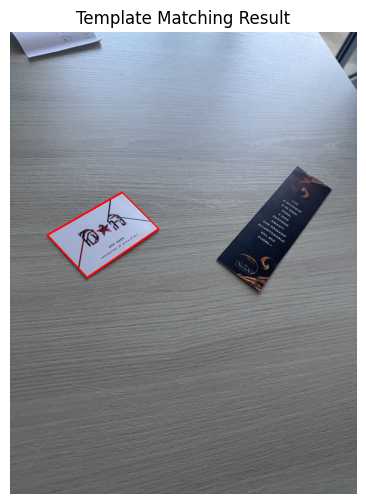

In [10]:
# Compute homography
H, mask, t_shape = template_match(
    template_path=template_path,
    scene_path=scene_path,
    extract_method='SIFT',
    match_method='BF'
)

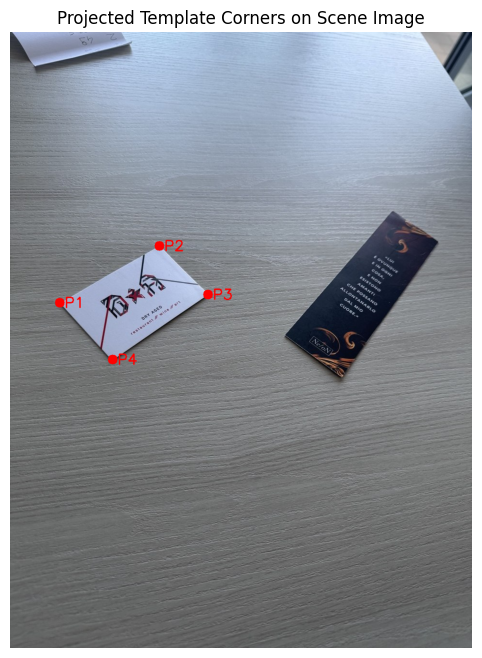

In [11]:
# Get the four corners of the template in pixel coordinates
corners_px = np.array([
    [0, 0],
    [t_shape[1], 0],
    [t_shape[1], t_shape[0]],
    [0, t_shape[0]]
], dtype=np.float32)

# Obtain their corresponding coordinates in the scene image
projected_corners = cv2.perspectiveTransform(corners_px.reshape(-1, 1, 2), H).reshape(-1, 2)

# Draw the projected corners on the scene image
for i in range(len(projected_corners)):
    offset = np.array([10, 10])  # Offset for text placement
    cv2.circle(scene_image, tuple(map(int, projected_corners[i])), 10, (255, 0, 0), -1)
    cv2.putText(scene_image, f'P{i+1}', tuple(map(int, projected_corners[i] + offset)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
# Show the scene image with projected corners
plt.figure(figsize=(10, 8))
plt.imshow(scene_image)
plt.title('Projected Template Corners on Scene Image')
plt.axis('off')
plt.show()

In [12]:
# Compute the metric-to-image homography
H_mm2px = compute_metric_homography(
    H_px=H,
    template_size_px=t_shape,
    template_size_metric=(template.height, template.width)
)

In [13]:
# Compatre the two homographies
print("Homography from template (px) to image (px):")
print(H)
print("\nHomography from template (metric) coordinates to image (px):")
print(H_mm2px)

# Compute the element-wise ratio of the two homographies
H_ratio = H_mm2px / H
# Print the ratio
print("\nElement-wise ratio of the two homographies:")
print(H_ratio)

Homography from template (px) to image (px):
[[ 2.80703105e-01  1.84151733e-01  1.03329568e+02]
 [-6.75941689e-02  1.80145277e-01  5.62712932e+02]
 [ 1.49989225e-04 -3.49659293e-05  1.00000000e+00]]

Homography from template (metric) coordinates to image (px):
[[ 2.91931177e+00  1.92857150e+00  1.03329567e+02]
 [-7.02980387e-01  1.88661403e+00  5.62712952e+02]
 [ 1.55988602e-03 -3.66185515e-04  1.00000000e+00]]

Element-wise ratio of the two homographies:
[[10.39999815 10.47273067  0.99999999]
 [10.40001525 10.47273655  1.00000003]
 [10.39998716 10.47263784  1.        ]]


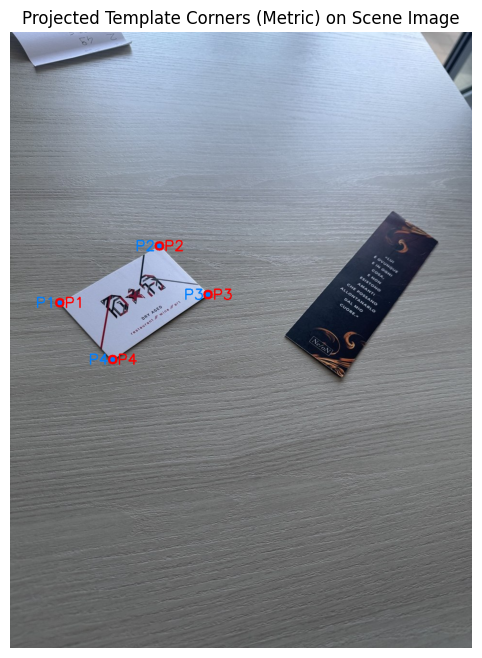

In [14]:
# Define the 4 template corners in mm coordinates, having template.width and template.height
corners_mm = np.array([
    [0, 0],
    [template.width, 0],
    [template.width, template.height],
    [0, template.height],
], dtype=np.float32)

# Test the metric-to-image homography
projected_mm_corners = cv2.perspectiveTransform(corners_mm.reshape(-1, 1, 2), H_mm2px).reshape(-1, 2)

# Draw the projected corners on the scene image
for i in range(len(projected_mm_corners)):
    offset = np.array([-50, 10])  # Offset for text placement
    cv2.circle(scene_image, tuple(map(int, projected_mm_corners[i])), 5, (0, 127, 255), -1)
    cv2.putText(scene_image, f'P{i+1}', tuple(map(int, projected_mm_corners[i] + offset)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 127, 255), 2)
# Show the scene image with projected corners
plt.figure(figsize=(10, 8))
plt.imshow(scene_image)
plt.title('Projected Template Corners (Metric) on Scene Image')
plt.axis('off')
plt.show()

In [15]:
# Compute the second homography using the derived method
H_derived = derive_metric_homography_from_pixel_homography(
    H_tpl2img=H,
    template_size_px=t_shape,
    template_size_metric=(template.height, template.width),
    template_origin_px=(0.0, 0.0),
    template_origin_metric=(0.0, 0.0)
)
# Compare the derived homography with the computed one
print("\nDerived Homography from template (metric) coordinates to image (px):")
print(H_derived)
# Compute the element-wise ratio of the derived homography and the computed one
H_derived_ratio = H_derived / H_mm2px
# Print the ratio
print("\nElement-wise ratio of the derived homography and the computed one:")
print(H_derived_ratio)


Derived Homography from template (metric) coordinates to image (px):
[[ 2.93972706e+00  1.91517802e+00  1.03329568e+02]
 [-7.07895296e-01  1.87351088e+00  5.62712932e+02]
 [ 1.57079625e-03 -3.63645665e-04  1.00000000e+00]]

Element-wise ratio of the derived homography and the computed one:
[[1.00699319 0.99305523 1.00000001]
 [1.00699153 0.99305468 0.99999997]
 [1.00699425 0.99306404 1.        ]]


In [16]:
# Define the template center in mm
C = np.array([template.width / 2, template.height / 2], dtype=np.float32)

# Compute distance from the camera center to the template center
distance_pred = compute_distance_from_homography(H_derived, K, C)
print(f"Distance to template center: {distance_pred:.2f} mm")

# True distance and error
distance_true = scene.get_distance('Camera', template.id).distance
error = np.abs(distance_pred - distance_true)
error_percent = (error / distance_true) * 100

print(f"True distance: {distance_true:.2f} mm")
print(f"Error: {error:.2f} mm ({error_percent:.2f}%)")
print(f"Relative error: {error_percent:.2f}%")

Distance to template center: 315.29 mm
True distance: 330.00 mm
Error: 14.71 mm (4.46%)
Relative error: 4.46%


In [17]:
# Create results directory if it doesn't exist
results_path = os.path.join(project_root, "results")
os.makedirs(results_path, exist_ok=True)

# Define the CSV path
csv_path = os.path.join(results_path, "measurement_results_v3.csv")

# Load or initialize the DataFrame
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
else:
    df = pd.DataFrame(columns=["scene", "from", "to", "predicted_distance", "true_distance", "error", "error_percentage"])

# Create the new row as a dictionary
row = {
    "scene": scene.id,
    "from": "Camera",
    "to": template.id,
    "predicted_distance": distance_pred,
    "true_distance": distance_true,
    "error": error,
    "error_percentage": error_percent
}

# Check if the row is already present
is_duplicate = ((df["scene"] == scene.id) & (df["from"] == "Camera") & (df["to"] == template.id)).any()

if not is_duplicate:
    # Append safely without FutureWarning
    df.loc[len(df)] = row
    df.to_csv(csv_path, index=False)
    print(f"✅ Results saved to {csv_path}")
else:
    print(f"ℹ️ Row already exists in {csv_path}, not saving.")

ℹ️ Row already exists in /home/stefano/projects/single-view-3d/results/measurement_results_v3.csv, not saving.
